**CONSOLIDATED**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install afinn

In [ ]:
# Import libraries 
import pandas as pd
import numpy as np
import json 
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.api.types import CategoricalDtype 
from sklearn import model_selection, metrics
from afinn import Afinn
import math



In [ ]:
df = pd.read_csv("/content/gdrive/MyDrive/Combined_dataset.csv")
df = df.drop('Unnamed: 0', axis=1)
print(df.shape)

(1000, 32)


In [ ]:
#Get name of cols
for i in range(0,32):
    print(df.columns[i])

backers_count
blurb
category
converted_pledged_amount
country
created_at
current_currency
deadline
fx_rate
goal
id
launched_at
location
name
pledged
profile
slug
source_url
spotlight
staff_pick
state
state_changed_at
static_usd_rate
urls
usd_pledged
usd_type
story
faq
num_faq
comments
n_comments
duration


In [ ]:
df.head(2)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,id,launched_at,location,name,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,story,faq,num_faq,comments,n_comments,duration
0,1,With your help we will create this device that...,"{""id"":331,""name"":""3D Printing"",""slug"":""technol...",1,ES,2015-08-18 21:01,USD,2016-07-09 20:11,1.212886,15000,1662798399,2016-06-09 20:11,"{""id"":55897673,""name"":""Mexico"",""slug"":""mexico-...",Save water 100% liquid downloads in toilets at...,1.0,"{""id"":2075449,""project_id"":2075449,""state"":""in...",save-water-100-liquid-downloads-in-toilets,https://www.kickstarter.com/discover/categorie...,False,False,failed,2016-07-09 20:11,1.136930,"{""web"":{""project"":""https://www.kickstarter.com...",1.136930,domestic,Producto Final\nHi! The funds we will used to ...,[' '],0,Only backers can post comments. Log in\nNo com...,0,30 days 00:00:00.000000000
1,2,We at Ormiston Primary are looking at starting...,"{""id"":309,""name"":""Farms"",""slug"":""food/farms"",""...",9,NZ,2015-08-11 18:04,USD,2015-09-11 15:55,0.723585,5000,1316288919,2015-08-12 15:55,"{""id"":22726370,""name"":""Flat Bush"",""slug"":""flat...",Ormiston Primary Community Garden,15.0,"{""id"":2063089,""project_id"":2063089,""state"":""in...",ormiston-primary-community-garden,https://www.kickstarter.com/discover/categorie...,False,False,failed,2015-09-11 15:55,0.655304,"{""web"":{""project"":""https://www.kickstarter.com...",9.829555,domestic,At Ormiston Primary School we are looking at c...,[' '],0,Only backers can post comments. Log in\nNo com...,0,30 days 00:00:00.000000000


In [ ]:
# Drop Duplicates
df = df.drop_duplicates('id', keep ='first')

In [ ]:
#Check for NA
df.isna().sum()

backers_count               0
blurb                       0
category                    0
converted_pledged_amount    0
country                     0
created_at                  0
current_currency            0
deadline                    0
fx_rate                     0
goal                        0
id                          0
launched_at                 0
location                    1
name                        0
pledged                     0
profile                     0
slug                        0
source_url                  0
spotlight                   0
staff_pick                  0
state                       0
state_changed_at            0
static_usd_rate             0
urls                        0
usd_pledged                 0
usd_type                    0
story                       5
faq                         0
num_faq                     0
comments                    0
n_comments                  0
duration                    0
dtype: int64

In [ ]:
# Convert numerical cols type to int/float
df['duration'] = pd.to_numeric(pd.to_timedelta(df['duration']).dt.days, downcast='integer')
df['num_faq'] = df['num_faq'].astype(int)
df['n_comments'] = df['n_comments'].str.replace(',', '').astype(float)

# Convert rows from str to dict
def string_to_dict(dict_string):
    # Convert to proper json format
    dict_string = dict_string.replace("'", "'").replace('u"', '"')
    return json.loads(dict_string)

df.category = df.category.apply(string_to_dict)

# Get category values from dictionary
df['parent_category'] = [d.get('parent_name') for d in df.category]
df['category_name'] = [d.get('name') for d in df.category]
df["parent_category"].fillna("No Parent Category", inplace = True)

# Get Location of Projects from location dict
def get_location(i):
    i = str(i).replace('nan', '{"name": ""}')
    i = i.replace('false', 'False')
    i = i.replace('null', '{"name": ""}')
    name_i = eval(i).get('name')
    if len(name_i) == 0:
        return None
    else:
        if name_i.isdigit():
            return None
        else:
            return name_i
    
df['location_name'] = df.location.apply(lambda x: get_location(x))

In [ ]:
# Fill na for text cols
df["story"].fillna(" ", inplace = True)

# Clean up comments 
df['comments'] = df['comments'].apply(lambda x: x.replace('Only backers can post comments. Log in\n',""))

print(df.shape)
df.sample(3)

(985, 35)


,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,id,launched_at,location,name,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,story,faq,num_faq,comments,n_comments,duration,parent_category,category_name,location_name
165,95,Madhu & Alex are returning to the studio to re...,"{'id': 44, 'name': 'World Music', 'slug': 'mus...",8670,US,2017-02-05 14:42,USD,2017-04-21 14:11,1.000000,7777,249877281,2017-02-21 22:14,"{""id"":2362930,""name"":""Berkeley"",""slug"":""berkel...",Madhu & Alex - The Sāmi Brothers,8670.22,"{""id"":2866644,""project_id"":2866644,""state"":""in...",madhu-and-alex-the-sami-brothers,https://www.kickstarter.com/discover/categorie...,True,False,successful,2017-04-21 14:11,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",8670.220000,domestic,"Support your brother, Madhu & Alex, getting ba...",[' '],0,Deb Epstein\nalmost 4 years ago\nCongratulatio...,6.0,58,Music,World Music,Berkeley
867,8,After recently creating a one-off vest for mys...,"{'id': 263, 'name': 'Apparel', 'slug': 'fashio...",264,GB,2015-02-23 15:19,USD,2015-03-25 15:35,1.384815,150,628807230,2015-02-23 15:35,"{""id"":37024,""name"":""Taunton"",""slug"":""taunton-g...",The VIRUS Empire Strix vest,178.00,"{""id"":1726262,""project_id"":1726262,""state"":""in...",the-virus-empire-strix-vest,https://www.kickstarter.com/discover/categorie...,True,False,successful,2015-03-25 15:35,1.539926,"{""web"":{""project"":""https://www.kickstarter.com...",274.106766,international,I wanted to use the artwork from my EP Strix o...,[' '],0,No comments yet.,0.0,30,Fashion,Apparel,Taunton
149,2,Drone Foods Delivery. For current time of need...,"{'id': 314, 'name': 'Spaces', 'slug': 'food/sp...",11,US,2020-03-17 2:03,USD,2020-04-16 3:53,1.000000,10000,465041186,2020-03-17 3:53,"{""id"":2442047,""name"":""Los Angeles"",""slug"":""los...",Drone Foods Delivery,11.00,"{""id"":3954395,""project_id"":3954395,""state"":""in...",drone-foods-delivery,https://www.kickstarter.com/discover/categorie...,False,False,failed,2020-04-16 3:53,1.000000,"{""web"":{""project"":""https://www.kickstarter.com...",11.000000,domestic,Why am I creating this? How did this idea com...,[' '],0,No comments yet.,0.0,30,Food,Spaces,Los Angeles


In [ ]:
#Get name of cols (after clean)
for i in range(0,34):
    print(df.columns[i])

backers_count
blurb
category
converted_pledged_amount
country
created_at
current_currency
deadline
fx_rate
goal
id
launched_at
location
name
pledged
profile
slug
source_url
spotlight
staff_pick
state
state_changed_at
static_usd_rate
urls
usd_pledged
usd_type
story
faq
num_faq
comments
n_comments
duration
parent_category
category_name


## EDA

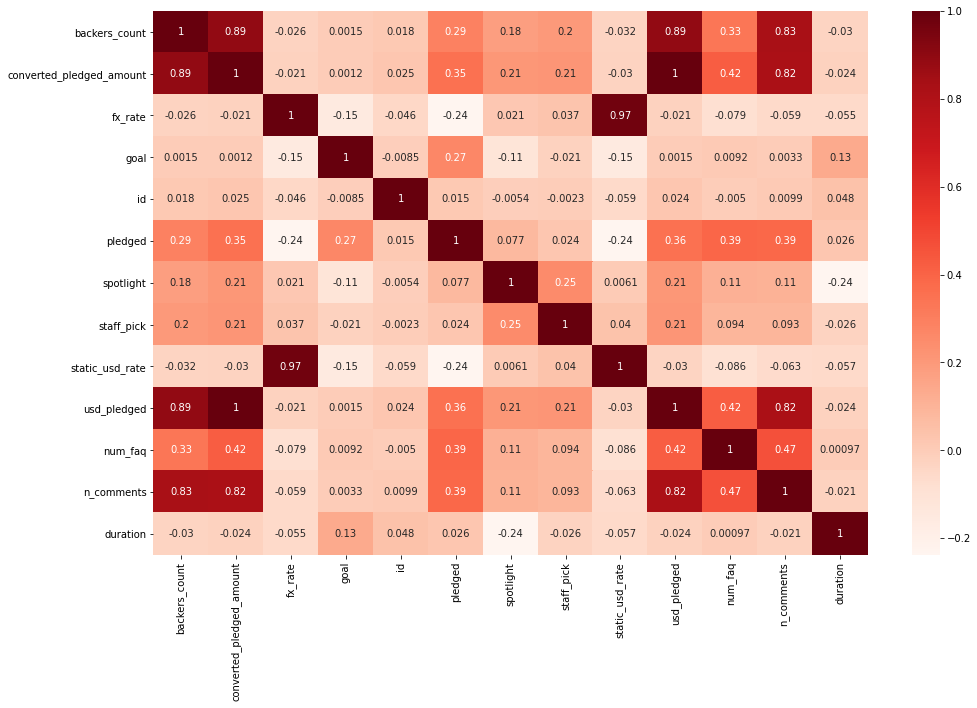

In [ ]:
# Get Correlation heatmap
plt.figure(figsize=(16,10))
cor = df.corr()
sns.heatmap(cor, annot=True, cmap=plt.cm.Reds)
plt.show()

Features with high correlation: 

1. converted_pledged_amount with usd_pledged,
2. static_usd_rate with fx_rate
3. usd_pledged with backers_count
4. state with spotlight
5. n_comments with converted_pledged_amount
6. n_comments with backers_count
7. converted_pledged_amount with converted_pledged_amount



## Feature Engineering

In [ ]:
# Separate cols by type
categorical_cols = ['country', 'staff_pick', 'usd_type', 'parent_category', 'category_name']
num_cols = ['backers_count', 'fx_rate', 'goal', 'pledged', 'num_faq', 'n_comments', 'duration']
text_cols = ['blurb', 'name', 'story', 'faq', 'comments']

In [ ]:
#Change state to binary (1 = success project, 0 = failed project)
df.state = df.state.astype('category').cat.codes

In [ ]:
# Get month/year of launch/deadline
df['month_launched'] = pd.DatetimeIndex(df['launched_at']).month.astype(int)
df['year_launched'] = pd.DatetimeIndex(df['launched_at']).year.astype(int)

In [ ]:
# Log Transformation
boxplot_features = ['backers_count', 'goal', 'pledged', 'duration', 'n_comments']

for feature in boxplot_features:
    new_col = feature + '_log'
    df[new_col] = df[feature].apply(lambda x: math.log(x+1))
    df[new_col] = (df[new_col] - df[new_col].mean())/df[new_col].std()

In [ ]:
# Boolean Transformation
df['num_faq_bool'] = df['num_faq'].apply(lambda x: np.where(x >0, 1, 0))

In [ ]:
# Average fund per backer
df['avg_fund_per_backer'] = df['pledged']/df['backers_count']
num_cols.append('avg_fund_per_backer')

/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 78.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.7/dist-packages/seaborn/categorical.py:1296: UserWarning: 38.2% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


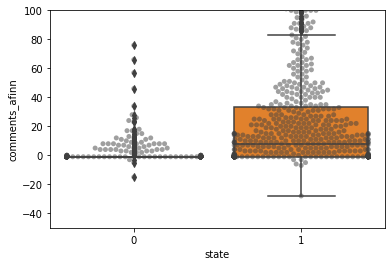

In [ ]:
# Add Afinn score for comments
afinn = Afinn(emoticons=True)
afinn_scores = [afinn.score(text) for text in df.comments]
df['comments_afinn'] = afinn_scores

sns.boxplot(x="state", y="comments_afinn", data=df).set(ylim=(-50, 100))
sns.swarmplot(x="state", y="comments_afinn", data=df, color=".25", alpha=0.5)

## Text Analysis

In [ ]:
# Extra text features to be analyzed by combining pre-existing text features
df['blurb_name'] = df['blurb'] + df['name']
# df['blurb_story'] = df['blurb'] + df['story']
# df['name_faq'] = df['name'] + df['faq']
# df['name_comments'] = df['name'] + df['comments']
df['faq_comments'] = df['faq'] + df['comments']

text_cols2 = ['blurb_name', 'faq_comments']
text_cols = text_cols + text_cols2

Save to output csv

In [ ]:
df.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'current_currency', 'deadline', 'fx_rate',
       'goal', 'id', 'launched_at', 'location', 'name', 'pledged', 'profile',
       'slug', 'source_url', 'spotlight', 'staff_pick', 'state',
       'state_changed_at', 'static_usd_rate', 'urls', 'usd_pledged',
       'usd_type', 'story', 'faq', 'num_faq', 'comments', 'n_comments',
       'duration', 'parent_category', 'category_name', 'location_name',
       'month_launched', 'year_launched', 'backers_count_log', 'goal_log',
       'pledged_log', 'duration_log', 'n_comments_log', 'num_faq_bool',
       'avg_fund_per_backer', 'comments_afinn', 'blurb_name', 'faq_comments'],
      dtype='object')

In [ ]:
df.sample(3)

,backers_count,blurb,category,converted_pledged_amount,country,created_at,current_currency,deadline,fx_rate,goal,id,launched_at,location,name,pledged,profile,slug,source_url,spotlight,staff_pick,state,state_changed_at,static_usd_rate,urls,usd_pledged,usd_type,story,faq,num_faq,comments,n_comments,duration,parent_category,category_name,location_name,month_launched,year_launched,backers_count_log,goal_log,pledged_log,duration_log,n_comments_log,num_faq_bool,avg_fund_per_backer,comments_afinn,blurb_name,faq_comments
4,10,The Horror Zine's Jeani Rector brings us anoth...,"{'id': 324, 'name': 'Anthologies', 'slug': 'pu...",340,US,2014-11-04 16:30,USD,2014-12-09 9:20,1.0,2500,1449353867,2014-11-09 9:20,"{""id"":2380358,""name"":""Cincinnati"",""slug"":""cinc...",Shrieks and Shivers from the Horror Zine,340.00,"{""id"":1491788,""project_id"":1491788,""state"":""in...",shrieks-and-shivers-from-the-horror-zine,https://www.kickstarter.com/discover/categorie...,False,False,0,2014-12-09 9:20,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",340.00,international,Table of Contents\n• TAPEWORM by Martin Rose\n...,[' '],0,Paula Limbaugh\nover 6 years ago\nSo sorry you...,1.0,30,Publishing,Anthologies,Cincinnati,11,2014,-0.457135,-0.260089,-0.289093,-0.012145,-0.232950,0,34.000000,2.0,The Horror Zine's Jeani Rector brings us anoth...,[' ']Paula Limbaugh\nover 6 years ago\nSo so...
621,11,"A haunted house in Orlando, FL. \nCreated by K...","{'id': 1, 'name': 'Art', 'slug': 'art', 'posit...",252,US,2020-08-08 21:38,USD,2020-10-02 1:00,1.0,250,950050737,2020-09-02 15:08,"{""id"":2466256,""name"":""Orlando"",""slug"":""orlando...",Hardin Haunt,252.00,"{""id"":4048775,""project_id"":4048775,""state"":""in...",hardin-haunt,https://www.kickstarter.com/discover/categorie...,True,False,1,2020-10-02 1:00,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",252.00,domestic,The Need for Halloween\nMy name is Kyle T. Har...,[' '],0,No comments yet.,0.0,29,No Parent Category,Art,Orlando,9,2020,-0.409492,-1.478753,-0.383543,-0.099817,-0.710711,0,22.909091,-1.0,"A haunted house in Orlando, FL. \nCreated by K...",[' ']No comments yet.
172,77,Help Brooklyn's favorite prairie-punks finish ...,"{'id': 43, 'name': 'Rock', 'slug': 'music/rock...",2700,US,2012-10-24 14:13,USD,2013-03-31 13:11,1.0,1500,596529739,2013-03-01 13:11,"{""id"":12589335,""name"":""Brooklyn"",""slug"":""brook...",GUNFIGHT! IS RECORDING A NEW ALBUM!,2700.01,"{""id"":383609,""project_id"":383609,""state"":""inac...",gunfight-is-recording-a-new-album,https://www.kickstarter.com/discover/categorie...,True,False,1,2013-03-31 13:11,1.0,"{""web"":{""project"":""https://www.kickstarter.com...",2700.01,international,"Hey everyone,\nGunFight! is hard at work on th...","["" Will this album be better or worse than you...",2,Anthony J. Lusardi III\nabout 5 years ago\nWha...,4.0,30,Music,Rock,Brooklyn,3,2013,0.615403,-0.530729,0.365749,-0.012145,0.398616,1,35.065065,26.0,Help Brooklyn's favorite prairie-punks finish ...,"["" Will this album be better or worse than you..."


In [ ]:
df["location_name"].fillna("None", inplace = True)
df["location"].fillna("None", inplace = True)
df["avg_fund_per_backer"].fillna(0, inplace = True)

In [ ]:
df.isna().sum()

backers_count               0
blurb                       0
category                    0
converted_pledged_amount    0
country                     0
created_at                  0
current_currency            0
deadline                    0
fx_rate                     0
goal                        0
id                          0
launched_at                 0
location                    0
name                        0
pledged                     0
profile                     0
slug                        0
source_url                  0
spotlight                   0
staff_pick                  0
state                       0
state_changed_at            0
static_usd_rate             0
urls                        0
usd_pledged                 0
usd_type                    0
story                       0
faq                         0
num_faq                     0
comments                    0
n_comments                  0
duration                    0
parent_category             0
category_n

In [ ]:
from google.colab import files
df.to_csv('data_clean&processed.csv')
files.download('data_clean&processed.csv')  

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>